In [13]:
# train_models.py
import os
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings("ignore")

In [14]:
# -------------------
# Config
# -------------------
DATASET_PATH = r"D:\Database\EuoroSat\EuroSATallBands"   # <- change to your dataset path
if not os.path.exists(DATASET_PATH):
    raise ValueError(f"Dataset path does not exist: {DATASET_PATH}")
else:
    print("Dataset path OK:", DATASET_PATH)
SAMPLE_PER_CLASS = 1000      # limit per class (adjust for memory)
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

Dataset path OK: D:\Database\EuoroSat\EuroSATallBands


In [15]:

# -------------------
# Utilities
# -------------------
def extract_features_from_tif(path, compute_indices=True):
    """
    Read a multispectral tif and return feature vector:
    - per-band mean (order B1..Bn)
    - optionally NDVI, NDBI, NDWI appended at end (if bands exist)
    """
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        # arr.shape = (bands, H, W)
        # compute mean per band
        band_means = arr.reshape(arr.shape[0], -1).mean(axis=1)
        feats = band_means.tolist()

        # Try to compute indices if possible (we assume typical sentinel band indices)
        # We don't assume exact band numbering in filenames; this expects standard order B1..B12
        if compute_indices and arr.shape[0] >= 8:
            # map: B4 (index 4) -> arr[3], B8 -> arr[7], B3 -> arr[2], B11 -> arr[10]
            def safe_mean(idx):
                if idx < arr.shape[0]:
                    a = arr[idx].reshape(-1)
                    denom = (a.sum() if a.sum() != 0 else 1.0)
                    return a.mean()
                return np.nan

            # compute NDVI (B8,B4)
            try:
                b8 = arr[7].reshape(-1).astype(np.float32)
                b4 = arr[3].reshape(-1).astype(np.float32)
                ndvi = (b8.mean() - b4.mean()) / (b8.mean() + b4.mean() + 1e-10)
            except Exception:
                ndvi = np.nan

            # NDBI (B11,B8)
            try:
                b11 = arr[10].reshape(-1).astype(np.float32)
                ndbi = (b11.mean() - b8.mean()) / (b11.mean() + b8.mean() + 1e-10)
            except Exception:
                ndbi = np.nan

            # NDWI (B3,B8)
            try:
                b3 = arr[2].reshape(-1).astype(np.float32)
                ndwi = (b3.mean() - b8.mean()) / (b3.mean() + b8.mean() + 1e-10)
            except Exception:
                ndwi = np.nan

            feats += [ndvi, ndbi, ndwi]

    return np.array(feats, dtype=np.float32)

In [16]:
# -------------------
# Build dataset (features + labels)
# -------------------
classes = sorted([c for c in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, c))])
print("Classes:", classes)

X_list = []
y_list = []
for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    files = [f for f in os.listdir(folder) if f.endswith('.tif') or f.endswith('.tiff') or f.endswith('.TIF')]
    if not files:
        continue
    files = files[:SAMPLE_PER_CLASS]
    for f in tqdm(files, desc=f"Reading {cls}"):
        path = os.path.join(folder, f)
        try:
            feats = extract_features_from_tif(path, compute_indices=True)
            X_list.append(feats)
            y_list.append(cls)
        except Exception as e:
            print("Skipping", path, "error:", e)

X = np.vstack(X_list)
y = np.array(y_list)
print("X shape:", X.shape, "y shape:", y.shape)


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'test_dataset']


Reading SeaLake: 100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]

X shape: (10000, 16) y shape: (10000,)


In [17]:
# -------------------
# Feature cleaning: handle NaN by simple imputation (mean)
# -------------------
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# -------------------
# Scale features
# -------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler + imputer
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))
joblib.dump(imp, os.path.join(MODEL_DIR, "imputer.joblib"))
print("Saved scaler & imputer")


Saved scaler & imputer


In [18]:

# -------------------
# 1) Supervised Random Forest
# -------------------
print("\nTRAINING RandomForest classifier...")
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
print("RandomForest accuracy:", accuracy_score(y_te, pred))
print(classification_report(y_te, pred))
joblib.dump(rf, os.path.join(MODEL_DIR, "rf_classifier.joblib"))
print("Saved RandomForest model.")



TRAINING RandomForest classifier...
RandomForest accuracy: 0.7905
                      precision    recall  f1-score   support

          AnnualCrop       0.77      0.74      0.76       200
              Forest       0.89      0.94      0.92       200
HerbaceousVegetation       0.79      0.85      0.82       200
             Highway       0.52      0.33      0.40       200
          Industrial       0.81      0.88      0.84       200
             Pasture       0.86      0.89      0.87       200
       PermanentCrop       0.74      0.77      0.75       200
         Residential       0.65      0.79      0.71       200
               River       0.81      0.73      0.77       200
             SeaLake       0.99      0.98      0.99       200

            accuracy                           0.79      2000
           macro avg       0.78      0.79      0.78      2000
        weighted avg       0.78      0.79      0.78      2000

Saved RandomForest model.


In [19]:
# -------------------
# 2) Unsupervised KMeans clustering + map clusters -> classes (majority voting)
# -------------------
print("\nTRAINING KMeans clustering...")
n_clusters = len(classes)
k_means = KMeans(n_clusters=n_clusters, random_state=40, n_init=15)
k_means.fit(X_scaled)

# Map clusters to classes by majority vote on training data
cluster_labels = k_means.labels_
mapping = {}
for cluster in range(n_clusters):
    idx = np.where(cluster_labels == cluster)[0]
    if len(idx) == 0:
        mapping[cluster] = "Unknown"
    else:
        # majority class among points in this cluster
        vals, counts = np.unique(y[idx], return_counts=True)
        mapping[cluster] = vals[np.argmax(counts)]

print("Cluster -> Class mapping:", mapping)
joblib.dump({'kmeans': k_means, 'mapping': mapping}, os.path.join(MODEL_DIR, "kmeans_cluster_and_map.joblib"))

# Evaluate clustering mapping
pred_cluster_class = np.array([mapping[c] for c in k_means.predict(X_scaled)])
print("Clustering mapped accuracy (on all data):", accuracy_score(y, pred_cluster_class))
print(confusion_matrix(y, pred_cluster_class, labels=classes))

print("\nTraining complete. Models saved in", MODEL_DIR)



TRAINING KMeans clustering...
Cluster -> Class mapping: {0: np.str_('PermanentCrop'), 1: np.str_('SeaLake'), 2: np.str_('River'), 3: np.str_('Residential'), 4: np.str_('Pasture'), 5: np.str_('AnnualCrop'), 6: np.str_('Industrial'), 7: np.str_('Forest'), 8: np.str_('SeaLake'), 9: np.str_('Pasture'), 10: np.str_('SeaLake')}
Clustering mapped accuracy (on all data): 0.4764
[[207   2   0   0  58 166 420 141   6   0   0]
 [  0 747   0   0   0 238   0   1  14   0   0]
 [ 49  61   0   0  83 145 207 354 101   0   0]
 [ 69 162   0   0  84 133  89 376  87   0   0]
 [166   0   0   0 660   6  43  55  70   0   0]
 [  0  11   0   0   5 881   4  94   5   0   0]
 [169  22   0   0  20  27 442 315   5   0   0]
 [ 64  10   0   0 206   0 110 402 208   0   0]
 [  0 247   0   0  32  80   6 190 441   4   0]
 [  0   0   0   0   2   0   0   0  14 984   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]

Training complete. Models saved in models


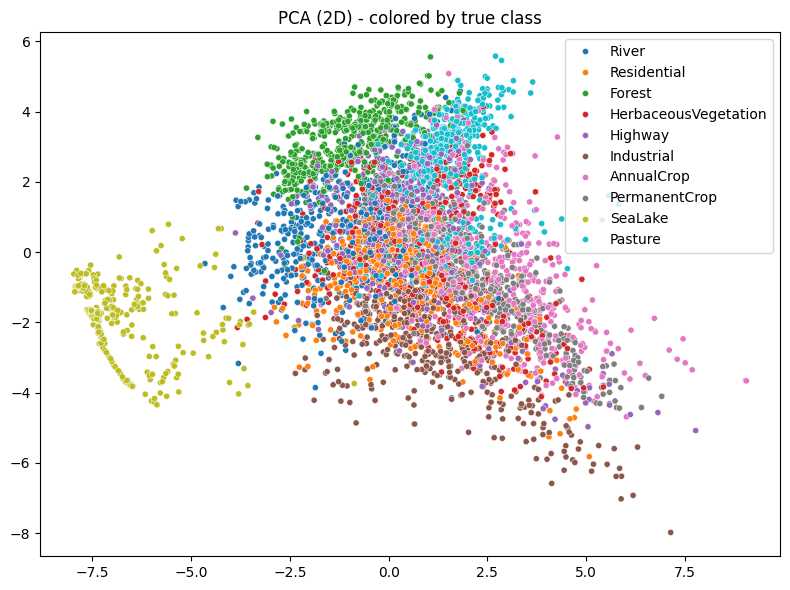

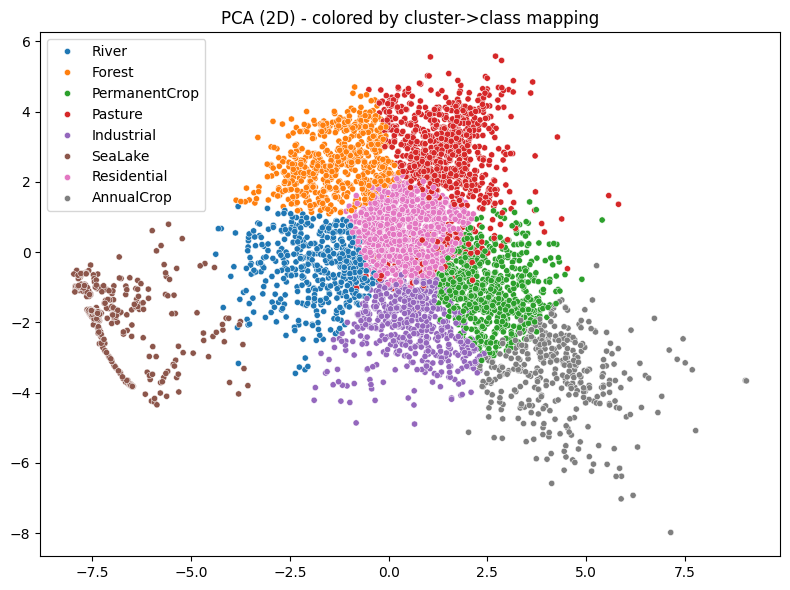

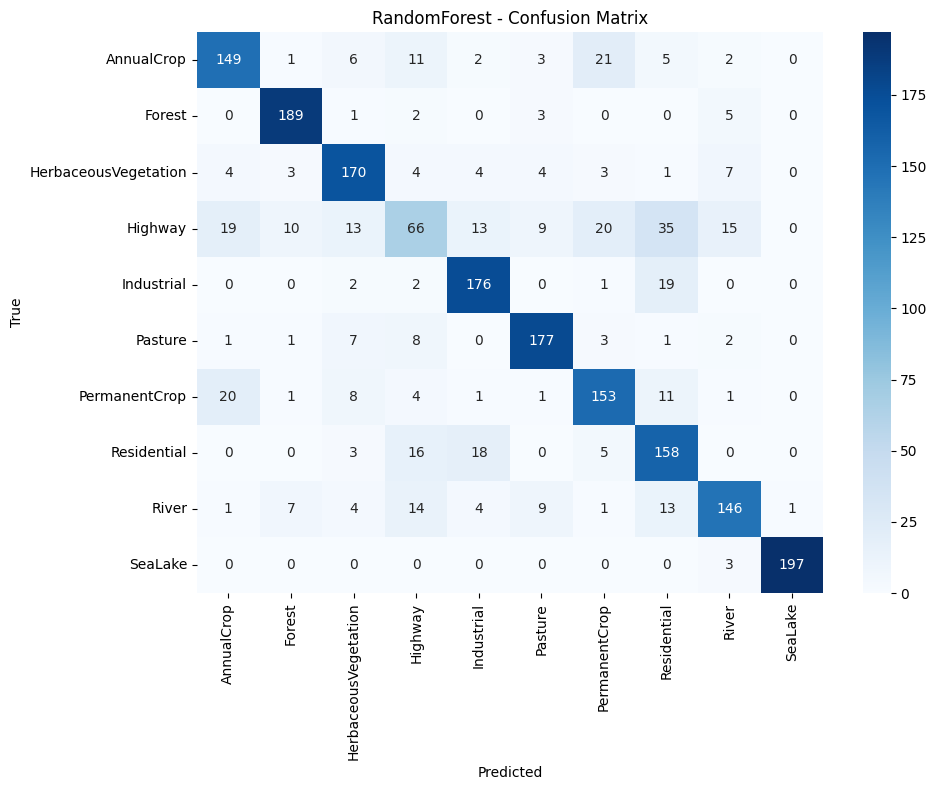

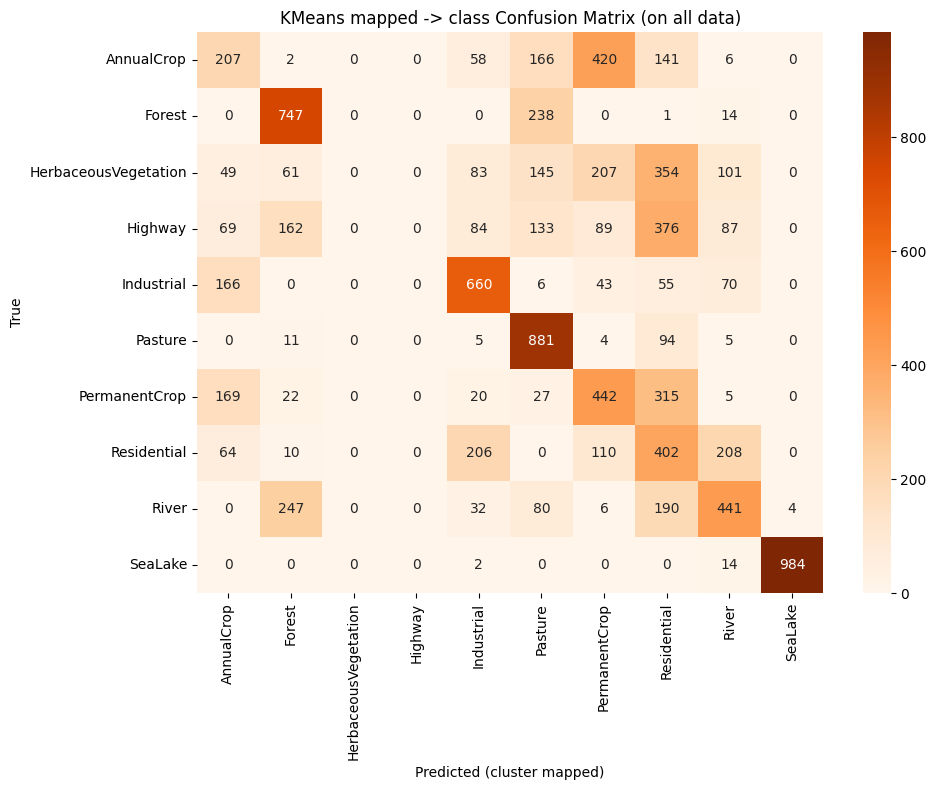

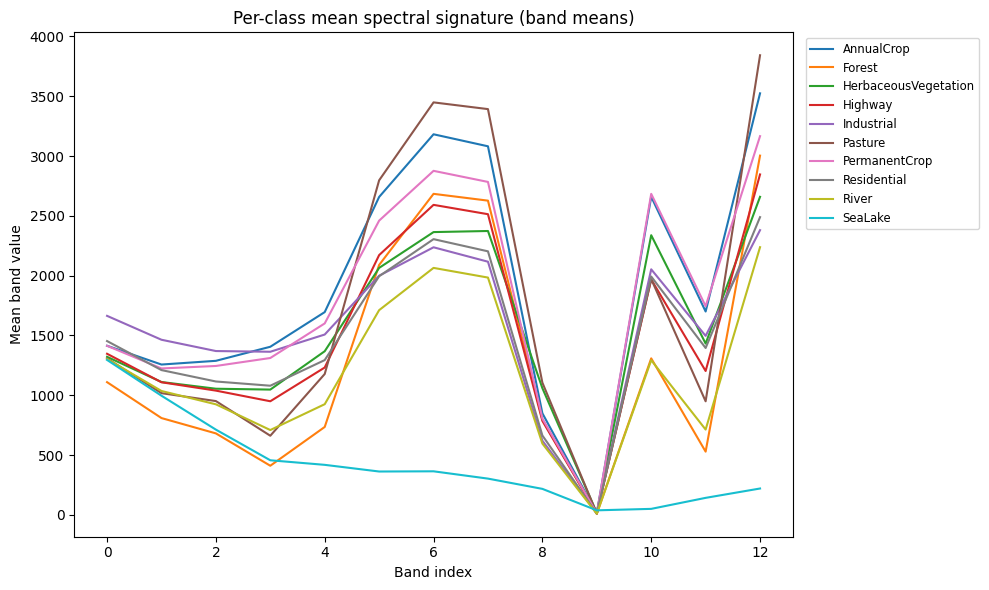

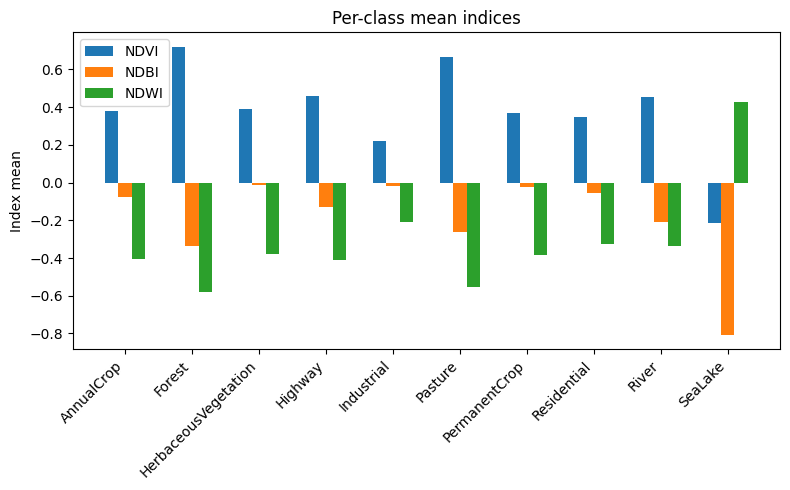

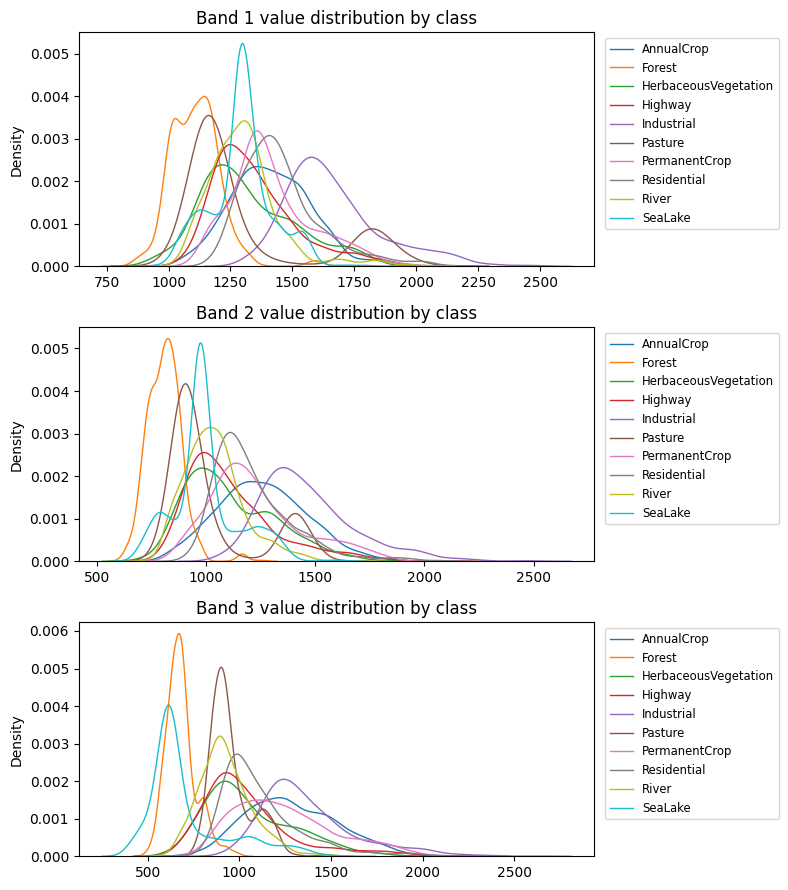

In [23]:
# New visualization cells (append after training / model-save cells)

# Cell: imports & helpers
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import numpy as np

FIG_DIR = os.path.join(MODEL_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def save_fig(fig, name, dpi=150):
    path = os.path.join(FIG_DIR, name)
    fig.tight_layout()
    fig.savefig(path, dpi=dpi)
    display(fig)
    plt.close(fig)

# Cell: PCA scatter (colored by true class and by cluster->class mapping)
# sample to speed up plotting if dataset large
sample_idx = np.arange(X_scaled.shape[0])
if X_scaled.shape[0] > 5000:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(X_scaled.shape[0], size=5000, replace=False)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled[sample_idx])

# map class names to ints/colors
unique_classes = np.array(sorted(list(set(y))))
class_to_int = {c:i for i,c in enumerate(unique_classes)}
colors = [class_to_int[c] for c in y[sample_idx]]

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=[unique_classes[i] for i in colors],
                palette="tab10", s=20, ax=ax, legend="full")
ax.set_title("PCA (2D) - colored by true class")
save_fig(fig, "pca_by_true_class.png")

# If KMeans exists, color by predicted cluster->class mapping
if 'k_means' in globals() and 'mapping' in globals():
    cluster_preds = k_means.predict(X_scaled[sample_idx])
    mapped = [mapping.get(c, "Unknown") for c in cluster_preds]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=mapped, palette="tab10", s=20, ax=ax, legend="full")
    ax.set_title("PCA (2D) - colored by cluster->class mapping")
    save_fig(fig, "pca_by_cluster_mapping.png")

# Cell: Confusion matrix for RF (test set) if RF trained
if 'pred' in globals() and 'y_te' in globals():
    cm = confusion_matrix(y_te, pred, labels=unique_classes)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("RandomForest - Confusion Matrix")
    save_fig(fig, "rf_confusion_matrix.png")

# Cell: Cluster->class confusion (evaluate mapping)
if 'pred_cluster_class' in globals():
    cm2 = confusion_matrix(y, pred_cluster_class, labels=unique_classes)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', xticklabels=unique_classes, yticklabels=unique_classes, ax=ax)
    ax.set_xlabel("Predicted (cluster mapped)")
    ax.set_ylabel("True")
    ax.set_title("KMeans mapped -> class Confusion Matrix (on all data)")
    save_fig(fig, "kmeans_mapped_confusion_matrix.png")

# Cell: Per-class spectral signature (mean feature vector)
# assume X columns: band means first, then optional NDVI,NDBI,NDWI (last up to 3)
n_features = X.shape[1]
# heuristic: if features > 6 treat first (n_features-3) as bands else all as bands
n_index_features = 0
if n_features >= 6:
    n_index_features = 3  # NDVI,NDBI,NDWI
n_bands = n_features - n_index_features if n_index_features>0 else n_features
band_idxs = list(range(n_bands))

fig, ax = plt.subplots(figsize=(10,6))
for cls in unique_classes:
    idx = np.where(y == cls)[0]
    if len(idx) == 0:
        continue
    mean_vec = np.nanmean(X[idx, :], axis=0)
    ax.plot(band_idxs, mean_vec[:n_bands], label=cls, linewidth=1.5)
ax.set_xlabel("Band index")
ax.set_ylabel("Mean band value")
ax.set_title("Per-class mean spectral signature (band means)")
ax.legend(bbox_to_anchor=(1.01,1), loc="upper left", fontsize="small")
save_fig(fig, "per_class_spectral_signature.png")

# If index features exist, plot them separately
if n_index_features > 0:
    idx_names = ["NDVI","NDBI","NDWI"][:n_index_features]
    fig, ax = plt.subplots(figsize=(8,5))
    for i, name in enumerate(idx_names):
        means = []
        for cls in unique_classes:
            idx = np.where(y == cls)[0]
            means.append(np.nanmean(X[idx, n_bands + i]))
        ax.bar(np.arange(len(unique_classes)) + i*0.2, means, width=0.2, label=name)
    ax.set_xticks(np.arange(len(unique_classes)) + 0.2)
    ax.set_xticklabels(unique_classes, rotation=45, ha="right")
    ax.set_ylabel("Index mean")
    ax.set_title("Per-class mean indices")
    ax.legend(loc="best")
    save_fig(fig, "per_class_indices.png")

# Cell: Per-band histograms for a few representative bands (first 3)
bands_to_plot = list(range(min(3, n_bands)))
fig, axes = plt.subplots(len(bands_to_plot), 1, figsize=(8, 3*len(bands_to_plot)))
if len(bands_to_plot)==1:
    axes = [axes]
for i, b in enumerate(bands_to_plot):
    ax = axes[i]
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        values = X[idx, b].ravel()
        sns.kdeplot(values, label=cls, ax=ax, linewidth=1)
    ax.set_title(f"Band {b+1} value distribution by class")
    ax.legend(fontsize="small", bbox_to_anchor=(1.01,1), loc="upper left")
save_fig(fig, "band_histograms.png")